In [78]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import plotly.express as px
import matplotlib.pyplot as plt
import MySQLdb
import datetime
import os
import json
import IPython
import time
ai_db = {'user' : 'id_user', 'pw' : 'password', 'ip' : '11.1.11.111', 'port' : 'xxxx', 'schema' : 'schema'}

In [80]:
sme_table_name = "schema.`tablename`"
sme_start_time = datetime.datetime(2021,11,15,0,0,0)
sme_end_time = datetime.datetime(2022,3,1,23,59,59)
sme_filter = "calltime between '"+str(sme_start_time)+"' and '"+str(sme_end_time)+"' and calltime not between '2022-01-28' and '2022-01-31'"#" and Day(calltime) < 27"
agent_data_filters = {'min_call_volume' : 50, 'in last how many days' : 30}#, 'agentid_incl_list' : 'all', 'agentid_excl_list' : 'all'}

binary_metric_column = "issale"
cont_metric_column = "revenue"

use_DOM_feature = True
use_DOW_feature = True
use_HOD_feature = True
use_month_feature = True

lookup_flag_columns =  {'btn_lookup': '_btnh', 'crm_lookup': '_crm'} # if NA flag column of a numeric column is high correlated with any of these, it will be dropped
exclude_NA_from_training = True  # drops rows/ calls with NA from training
null_indicator = 'NA'

feature_configs_file_name = 'feature_preprocess_configs.txt'

feature_column_names = """feature1, feature2, feature3, feature4, feature5"""

crm_features = """feature1, feature2, feature3, feature4, feature5"""

btn_features = """feature1, feature2, feature3, feature4, feature5"""
 
feature_column_names = feature_column_names + ',' + """vdn"""
feature_column_names = feature_column_names + ',' + crm_features
feature_column_names = feature_column_names + ',' + btn_features

#### Setting up for query

In [81]:
### Turn str type feature list to list type
if isinstance(feature_column_names,str):
    feature_list = list(set(feature_column_names.lower().replace('\n','').replace(' as ','abcdefghij').replace(' ', '').replace('abcdefghij',' as ').split(',')))
else:
    feature_list = feature_column_names
print(feature_list)
# print(feature_list)
### create columns part of query
sme_columns = ""
my_list = feature_list+list(lookup_flag_columns.keys())
for i,feature_name in enumerate(my_list):   # lower case as well
    sme_columns = sme_columns+my_list[i]+' as '+my_list[i].lower()+', '
sme_columns = sme_columns + binary_metric_column + ' as ' + binary_metric_column.lower() +', '+ cont_metric_column + ' as ' + cont_metric_column.lower() + ', '
sme_columns = sme_columns + 'calltime as calltime, on_off as on_off, agentid as agentid'

['ncalls_services_renewals_btnh', 'lastcall_rgu_btnh', 'h_minexp_bucket_crm_hh', 'h_ismotorinsurance_crm_hh', 'h_policies_sold_hh_crm_hh', 'ncalls_noarea_btnh', 'months_since_first_call_btnh', 'lastcall_issale_btnh', 'h_minexp_bin_crm_hh', 'h_total_active_policies_sold_crm_hh', 'months_since_last_call_noarea_btnh', 'previous_vdn', 'h_pol_bin_crm_hh', 'ncalls_1year_btnh', 'h_total_policies_sold_crm_hh', 'weeks_since_last_call_noarea_btnh', 'h_hpshr_crm_hh', 'h_total_quotes_crm_hh', 'weeks_since_last_call_services_renewals_btnh', 'h_age_bucket_crm_hh', 'h_pol_active_bucket_crm_hh', 'h_max_tenure_crm_hh', 'ncalls_1month_btnh', 'ncalls_btnh', 'h_total_quotes_hh_crm_hh', 'months_since_last_call_btnh', 'ncalls_180days_btnh', 'handletime_5_lastcall_btnh', 'h_pol_bucket_crm_hh', 'h_min_tenure_crm_hh', 'months_since_last_call_services_renewals_btnh', 'h_total_quotes_mt_crm_hh', 'h_btn_count_crm_hh', 'ncalls_renewals_btnh']


In [ ]:
ai_connection = MySQLdb.connect(user=ai_db['user'],passwd=ai_db['pw'],host=ai_db['ip'],port = int(ai_db['port']))
df_sme = pd.read_sql_query("Select "+sme_columns+" from "+sme_table_name+' where '+sme_filter+';', con=ai_connection)
df_sme['on_off'] = pd.to_numeric(df_sme.on_off)
df_sme["day_of_month"] = pd.DatetimeIndex(df_sme.calltime).day
df_sme['day_of_week'] = pd.DatetimeIndex(df_sme.calltime).weekday
df_sme['hour_of_day'] = pd.DatetimeIndex(df_sme.calltime).hour
df_sme['month'] = pd.DatetimeIndex(df_sme.calltime).month
df_sme["calls"] = 1
for lookup in lookup_flag_columns:
    df_sme[lookup] = pd.to_numeric(df_sme[lookup])
df_sme = df_sme.reindex()
print("Total calls:", len(df_sme))

#### Agent call volumes

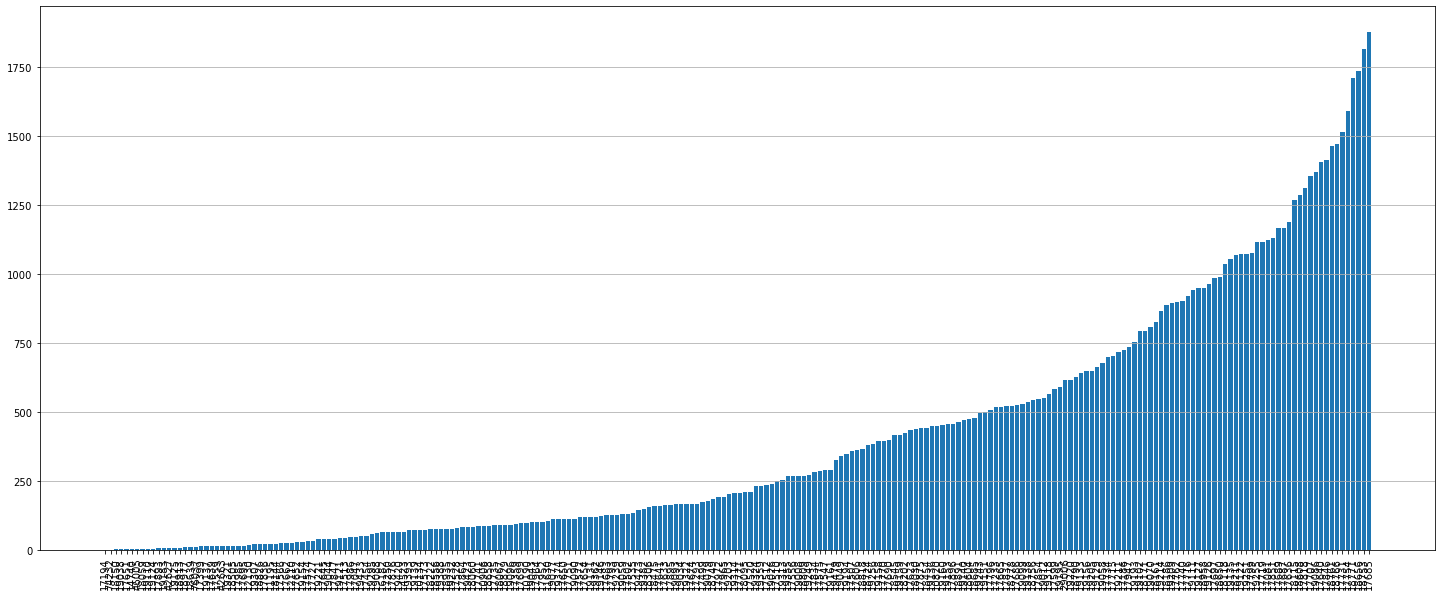

In [7]:
df_plot = df_sme[["agentid", "calls"]].groupby("agentid").count().sort_values(by='calls')
# fig = px.bar(x=df_plot.index, y=df_plot.calls, title="Agent Call Volumes")
# # fig = px.bar(df_sme[df_sme.calltime>datetime.datetime(2022,2,1)], x='agentid', y='calls', title="Agent Call Volumes")
# fig.show()
fig, axis = plt.subplots(1,1,figsize=(25, 10))
plt.bar(df_plot.index, df_plot.calls)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

#### Filtering based on agent filter

In [8]:
ncalls_before = len(df_sme)
nagents_before = len(df_sme.agentid.unique())

td_period = datetime.timedelta(days=agent_data_filters['in last how many days'])
df_agent_call_volumes = df_sme[["agentid", "calls"]][df_sme.calltime>sme_end_time-td_period].groupby("agentid").count()
valid_agentids = list(df_plot.index[df_plot.calls >= agent_data_filters['min_call_volume']])

df_sme = df_sme.drop(df_sme.index[~(df_sme.agentid.isin(valid_agentids))])
print("Total calls dropped:", ncalls_before - len(df_sme))
print("Total calls left:", len(df_sme))
print("Total agents dropped:", nagents_before - len(df_sme.agentid.unique()))
print("Total agents left:", len(df_sme.agentid.unique()))

Total calls dropped: 887
Total calls left: 93119
Total agents dropped: 48
Total agents left: 190


#### Train-Validate-Test Splits
###### df_sme should have a 'data_split' column after this cell filled with 'train', 'validate', 'test' values

In [9]:
df_sme['data_filter'] = 0  # 0 to include, 1 to exclude
if exclude_NA_from_training == True:
    for f in feature_list: df_sme['data_filter'] = np.where(df_sme[f]==null_indicator, 1, df_sme.data_filter)
#################################
df_sme['data_split'] = 'train'
df_sme['temp_random'] = np.random.rand(len(df_sme))
D30 = datetime.timedelta(days=30)
df_sme['data_split'] = np.where((df_sme.calltime > sme_end_time-datetime.timedelta(days=30))&(df_sme.on_off==0)&(df_sme.temp_random>0.6), 'test', df_sme.data_split)
df_sme['data_split'] = np.where((df_sme.calltime > sme_end_time-datetime.timedelta(days=15))&(df_sme.on_off==0)&(df_sme.temp_random>0.5), 'test', df_sme.data_split)
df_sme['temp_random'] = np.where((df_sme.data_split!='test'), np.random.rand(len(df_sme)), 0)
# df_sme['data_split'] = np.where((df_sme.data_split!='test')&(df_sme.temp_random>0.85), 'validate', df_sme['data_split'])

print("Train size:", len(df_sme[(df_sme.data_split=='train')&(df_sme.data_filter==0)]))
# print("Validate size:", len(df_sme[(df_sme.data_split=='validate')&(df_sme.data_filter==0)]))
print("Test size:", len(df_sme[(df_sme.data_split=='test')]))

Train size: 31975
Validate size: 5697
Test size: 6394


#### Feature Representations
###### Normalise, one/multi-hot encode, and everything else ... and also drop outliers

In [10]:
def preprocess_smalls(column_pdseries, smalls):
    if 0 <= smalls < 1:
        vc = column_pdseries.value_counts() < smalls*len(df_sme)
    elif smalls >= 1:
        vc = column_pdseries.value_counts() < smalls
    return column_pdseries.replace(vc.index[vc==True].tolist(), 'smalls')

def plot_feature(feature_column, target_metric):
    try:
        df_plot = pd.pivot_table(df_sme[[feature_column,'calls', target_metric]][~(df_sme[f].isin([null_indicator, np.nan, 'nan', None]))].apply(pd.to_numeric, axis=1),#, errors='coerce'),
                                 values = ['calls', target_metric], index = feature_column, aggfunc = {'calls' : np.sum, target_metric : np.mean}).sort_index()
        rolling_window = int(2*np.ceil((df_plot.index.max()-df_plot.index.min())/30) + 1)
        df_plot['rolling_avg'] = (df_plot.calls * df_plot[target_metric]).rolling(rolling_window, center=True).sum() / df_plot.calls.rolling(rolling_window, center=True).sum()
        df_plot['NA'] = df_sme[target_metric][(df_sme[f].isin([null_indicator, np.nan, 'nan', None]))].mean()
        NA_callvolume = len(df_sme[(df_sme[f].isin([null_indicator, np.nan, 'nan', None]))])
    except Exception as e:
        #print(rolling_avg_window, e)
        df_plot = pd.pivot_table(df_sme[[feature_column,'calls', target_metric]],
                                 values = ['calls', target_metric], index = feature_column, aggfunc = {'calls' : np.sum, target_metric : np.mean})
    #display(df_plot.head())
    fig, ax = plt.subplots(1,1,figsize=(25, 8))
    ax2 = ax.twinx()
    ax.bar(df_plot.index, df_plot.calls)
    ax2.plot(df_plot.index, df_plot[target_metric], 'r', label='avg')
    if 'rolling_avg' in list(df_plot.columns):
        ax2.plot(df_plot.index, df_plot.rolling_avg, 'k',label=str(rolling_window)+' rolling avg')
        ax2.plot(df_plot.index, df_plot.NA, 'grey',label='NA avg ('+str(NA_callvolume)+' calls)')
    plt.title(f)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.legend()
    plt.show()
    
def get_input_feature_type(feature_column):
    while True:
        user_input = input(feature_column+':')
        if user_input in ['C','N','B','0']:
            return {'type' : user_input, 'bins' : ''}
        elif user_input[0]=='B':
            bins_str = user_input[2:].split(' ')
            bins = []
            for b in bins_str:
                try:
                    bins.append(float(b))
                except Exception as e:
                    print(b, ':', e)
            print('Your Bins:', bins)
            return {'type' : 'B', 'bins' : bins}
        print('Enter a valid type.')
        
def preprocess_binning(feature_column, bins=None):
    # print('binning performed')
    featc = pd.to_numeric(df_sme[feature_column].replace(null_indicator, np.nan))
    if isinstance(bins, list):
        return pd.cut(featc, bins=bins, labels = False).astype(str)
    else:
        return pd.cut((featc-featc.mean()) / featc.std(), bins=[-100, -3, -1, -0.25, 0.25, 1, 3, 100], labels = False).astype(str)
    
def preprocess_drop_outliers(feature_column, threshold):
    # print('outlier dropped')
#     m = df_sme[feature_column].mean()
#     s = df_sme[feature_column].std()
#     df_sme['data_filter'] = np.where(abs( (df_sme[feature_column] - m) / s ) <= threshold, 1, df_sme.data_filter)
    featc = pd.to_numeric(df_sme[feature_column].replace(null_indicator, np.nan))
    m = featc.mean()
    s = featc.std()
    df_sme['data_filter'] = np.where(abs( (featc - m) / s ) >= threshold, 1, df_sme.data_filter)
    
def read_feature_configs(file_name):
    cd = os.getcwd()
    try:
        with open(cd+'/'+file_name, "r") as text_file:
            data = text_file.read().replace("'","\"").replace('\n', '')
            #data = data.replace('N', '')
            feature_configs = json.loads(data)
        text_file.close()
    except Exception as e:
        print('Error in importing feature types:', e)
        time.sleep(4)
        feature_configs = {}
    return feature_configs
def write_feature_configs(file_name, feature_config_dict):
    cd = os.getcwd()
    with open(cd+'/'+file_name, 'w') as text_file:
        text_file.write(str(feature_config_dict).replace("'","\"")) # replacing ' with " because json module needs " for keys while reading
    text_file.close()

In [11]:
# If this cell gets stuck. just interupt the kernel and re-run again
drop_outliers = True
outlier_stddev_threshold = 3
smalls_thresh = 0.01  # float b/w 0 and 1 or int

feature_layer_columns = []
feature_configs = read_feature_configs(feature_configs_file_name)
    
feature_list_transformed = feature_list.copy()
feature_list_transformed.append('agentid')
if use_DOM_feature == True: feature_list_transformed.append('day_of_month')
if use_DOW_feature == True: feature_list_transformed.append('day_of_week')
if use_HOD_feature == True: feature_list_transformed.append('hour_of_day')
if use_month_feature == True: feature_list_transformed.append('month')
    
feature_list_transformed = feature_list_transformed + list(lookup_flag_columns.keys())
additional_feature_transforms = []
for i,f in enumerate(feature_list_transformed):
    if f not in list(feature_configs.keys()) or feature_configs[f]['type'].lower() not in ['c','n','b']:
        IPython.display.clear_output(wait=True)
        plot_feature(f, binary_metric_column)
        print('Enter intended type of feature as \n \'N\': Numeric  | \'C\': Categorical  | \'B\': Binned Numeric | \'0\': to exclude')
        feature_configs[f] = get_input_feature_type(f)
        if feature_configs[f]['type'] != '0': write_feature_configs(feature_configs_file_name, feature_configs)
        else:
            feature_list_transformed[i] = ['excluded_feature']
            del feature_configs[f]
            continue
    if feature_configs[f]['type'].lower() == 'B'.lower(): #or (feature_configs[f]['type'].lower() == 'N'.lower() and exclude_NA_from_training != True) :
        if drop_outliers == True: preprocess_drop_outliers(f, threshold= outlier_stddev_threshold)
        df_sme[f+'_binned'] = preprocess_binning(f, bins=feature_configs[f]['bins'])
        feature_list_transformed[i] = f+'_binned'
        df_sme[f+'_binned'] = preprocess_smalls(df_sme[f+'_binned'], smalls_thresh)
        feature_layer_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(f+'_binned', vocabulary_list = list(df_sme[f+'_binned'].unique()))))
    elif feature_configs[f]['type'].lower() == 'N'.lower():
        df_sme[f+'_norm'] = pd.to_numeric(df_sme[f].replace(null_indicator, np.nan))
        if drop_outliers == True: preprocess_drop_outliers(f, threshold= outlier_stddev_threshold)
        if exclude_NA_from_training == False:  # Treat NA/Null values
            for lookup in lookup_flag_columns.keys():
                if lookup_flag_columns[lookup] in f:
                    mis_match_rate = np.where(df_sme[lookup] == np.where(df_sme[f+'_norm'].isna(), 0, 1), 0, 1).mean()
                    #print(f+'_null_indicator:', mis_match_rate)
                    if mis_match_rate > 0.02:
                        df_sme[f+'_null_indicator'] = np.where(df_sme[f+'_norm'].isna(), 0, 1)#.astype(str)
                        #print(f+'_null_indicator:',df_sme[f+'_null_indicator'].sum())
                        additional_feature_transforms.append(f+'_null_indicator')
                        feature_layer_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(f+'_null_indicator', vocabulary_list = list(df_sme[f+'_null_indicator'].unique()))))
        df_sme[f+'_norm'] = np.where(~(df_sme[f+'_norm'].isna()), (df_sme[f+'_norm']-df_sme[f+'_norm'].mean()) / df_sme[f+'_norm'].std(), 0)
        feature_list_transformed[i] = f+'_norm'
        feature_layer_columns.append(tf.feature_column.numeric_column(f+'_norm'))
    elif feature_configs[f]['type'].lower() == 'C'.lower():
        df_sme[f+'_cat'] = df_sme[f].astype(str)
        if f != 'agentid': df_sme[f+'_cat'] = preprocess_smalls(df_sme[f+'_cat'], smalls_thresh)
        feature_list_transformed[i] = f+'_cat'
        feature_layer_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(f+'_cat', vocabulary_list = list(df_sme[f+'_cat'].unique()))))

feature_list_transformed = feature_list_transformed + additional_feature_transforms
feature_list_transformed = list(filter(lambda a: a != 'excluded_feature', feature_list_transformed))
my_feature_layer = tf.keras.layers.DenseFeatures(feature_layer_columns)

IPython.display.clear_output(wait=True)
print("Train size:", len(df_sme[(df_sme.data_split=='train')&(df_sme.data_filter==0)]))
print("Validate size:", len(df_sme[(df_sme.data_split=='validate')&(df_sme.data_filter==0)]))
print("Test size:", len(df_sme[(df_sme.data_split=='test')]))

Train size: 27099
Validate size: 4845
Test size: 6394


In [42]:
[j/10 for j in range(10+1)]

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

## Model

#### Train Neural Network / any predictor

In [75]:
# def plot_loss_curve(epochs, hist, list_of_metrics):
#     plt.figure()
#     plt.xlabel("Epoch")
#     plt.ylabel("Value")
#     for m in list_of_metrics:
#         x = hist[m]
#         plt.plot(epochs[1:], hist[m][1:], label=m)
#     plt.legend(loc='upper right', bbox_to_anchor=(1.4,1))
    
def plot_loss_curve(epochs, hist, list_of_metrics, n_fold=-100):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], hist[m][1:], label=m)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4,1))
    if n_fold==-100: plt.title('Training History')
    else: plt.title('Training History (Fold: '+str(n_fold)+')')
    plt.show()

def create_model(my_learning_rate, my_feature_layer, hidden_layer_units):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    for i,u in enumerate(hidden_layer_units):
        model.add(tf.keras.layers.Dense(units = u,
                                        activation = 'relu',
                                        name='Hidden'+str(i)))
#         if i >= len(hidden_layer_units)-1: model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Dense(units=1, name='Output'))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                   loss='BinaryCrossentropy',
                   metrics=['accuracy', precision, recall, F1_score])
    return model

def train_model(model, dataset, label_name, epochs,
                batch_size=None, validation_split=0.1):
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
#     print(features)
#     print(label)
    history = model.fit(x=features, y=label, batch_size=batch_size,
                        epochs=epochs, shuffle=True)#, validation_split=validation_split)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

import keras.backend as K
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [76]:
# learning_rate = 0.0003  # relu: 0.0007
# n_epochs = 150
# batch_size = 4000
# hidden_layers=[25,20,20,12]

# del my_model
# my_model = create_model(learning_rate, my_feature_layer,
#                         hidden_layer_units=hidden_layers)

# epochs, hist = train_model(my_model,
#                            dataset = df_sme[feature_list_transformed+[binary_metric_column]][(df_sme.data_split=='train')&(df_sme.data_filter==0)],
#                            label_name = binary_metric_column, 
#                            epochs=n_epochs, batch_size=batch_size)
# list_of_metrics_to_plot = ['accuracy', 'precision', 'recall', 'F1_score']
# plot_loss_curve(epochs, hist, list_of_metrics_to_plot)

# val_features = {name:np.array(value) for name, value in df_sme[feature_list_transformed+[binary_metric_column]][(df_sme.data_split=='validate')&(df_sme.data_filter==0)].items()}
# test_label = np.array(val_features.pop(binary_metric_column))
# model_evaluation = my_model.evaluate(x= val_features, y= test_label, batch_size= batch_size)
# IPython.display.clear_output(wait=True)
# print('VALIDATION SET')
# for i, m in enumerate(['loss']+list_of_metrics_to_plot):
#     if i>0: print(m+':', round(model_evaluation[i], 4))


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,means
accuracy,0.700819,0.672775,0.687837,0.689871,0.711587,0.692578
precision,0.726358,0.686276,0.698996,0.702448,0.728462,0.708508
recall,0.847254,0.902308,0.882997,0.903240,0.900190,0.887198
F1_score,0.782137,0.779442,0.779673,0.790222,0.805272,0.787349


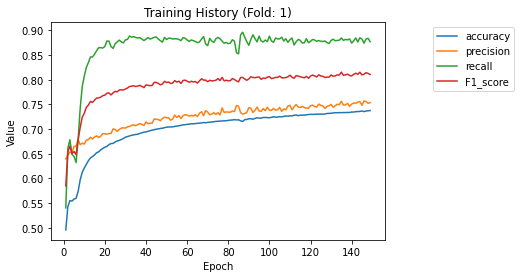

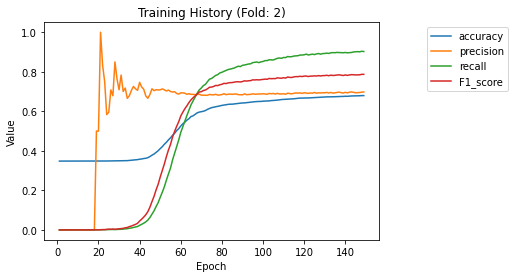

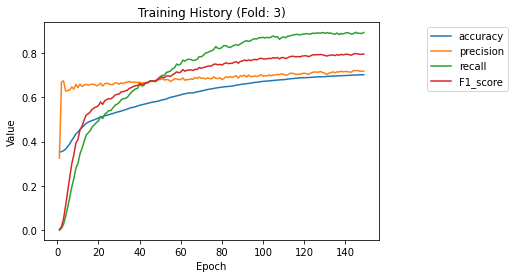

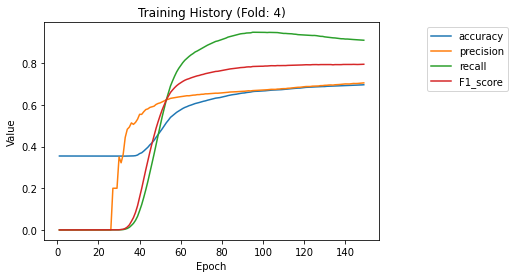

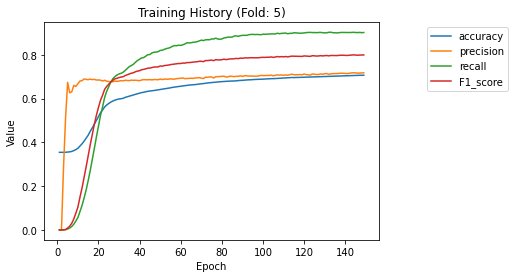

In [77]:
learning_rate = 0.0003  # relu: 0.0007
n_epochs = 150
batch_size = 4000
hidden_layers=[25,20,20,12]
n_folds = 5

list_of_metrics_to_plot = ['accuracy', 'precision', 'recall', 'F1_score']
train_histories = []
df_validations = pd.DataFrame(index = list_of_metrics_to_plot)
for i in range(n_folds):
    if i>0: del my_model
    print('FOLD: '+str(i+1))
    my_model = create_model(learning_rate, my_feature_layer,
                            hidden_layer_units=hidden_layers)
    train_filter = (df_sme.data_split=='train')&~(df_sme.temp_random.between(i/n_folds,(i+1/n_folds),inclusive='left'))&(df_sme.data_filter==0)
    validate_filter = (df_sme.data_split=='train')&(df_sme.temp_random.between(i/n_folds,(i+1/n_folds),inclusive='left'))&(df_sme.data_filter==0)
    epochs, hist = train_model(my_model,
                               dataset = df_sme[feature_list_transformed+[binary_metric_column]][train_filter],
                               label_name = binary_metric_column, 
                               epochs=n_epochs, batch_size=batch_size)
    train_histories.append({'epochs': epochs, 'hist': hist})
    val_features = {name:np.array(value) for name, value in df_sme[feature_list_transformed+[binary_metric_column]][validate_filter].items()}
    test_label = np.array(val_features.pop(binary_metric_column))
    model_evaluation = my_model.evaluate(x= val_features, y= test_label, batch_size= batch_size)
    df_validations['Fold '+str(i+1)] = model_evaluation[1:]
    IPython.display.clear_output(wait=False)
df_validations['means'] = df_validations.replace(0,np.nan).T.mean()
display(df_validations)
for i in range(n_folds): plot_loss_curve(train_histories[i]['epochs'], train_histories[i]['hist'], list_of_metrics_to_plot, n_fold=i+1,)

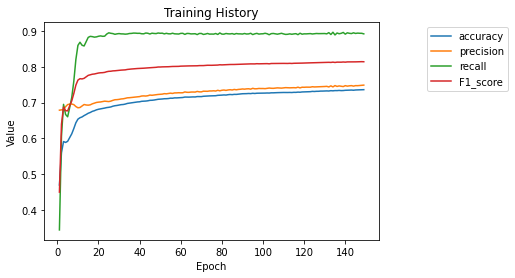

In [65]:
del my_model
my_model = create_model(learning_rate, my_feature_layer,
                        hidden_layer_units=hidden_layers)
epochs, hist = train_model(my_model,
                           dataset = df_sme[feature_list_transformed+[binary_metric_column]][(df_sme.data_split.isin(['train','validate']))&(df_sme.data_filter==0)],
                           label_name = binary_metric_column, 
                           epochs=n_epochs, batch_size=batch_size)
IPython.display.clear_output(wait=True)
plot_loss_curve(epochs, hist, list_of_metrics_to_plot)

#### Getting Agent Impact Scores

In [66]:
agentIDs = df_sme.agentid_cat.unique()
df_sme['synth_filter'] = np.where((df_sme.data_split.isin(['train','validate']))&(df_sme.data_filter==0), True, False)
l = len(df_sme)
temp_dfs = []
final_dfs = []
run_batch_proportion = 1
check = run_batch_proportion
for i , row in df_sme[feature_list_transformed][(df_sme.synth_filter)].iterrows():#, row_index in enumerate(list(df_sme.index)): # in case of non-numeric index   
    df_to_add = pd.DataFrame([row] * len(agentIDs))#, columns = feature_list_transformed)
    df_to_add.agentid_cat = agentIDs
    df_to_add['call_id'] = i
    temp_dfs.append(df_to_add)
    IPython.display.clear_output(wait=True)
    print(round(i*100/l,1),'%')
    if i*100/l > check: 
        df_synthesized = pd.concat(temp_dfs, ignore_index = True)
        temp_dfs = []
        synth_features = {name:np.array(value) for name, value in df_synthesized[feature_list_transformed].items()}
        df_synthesized['prediction_score'] = my_model.predict(x= synth_features, batch_size= batch_size)
        final_dfs.append(pd.pivot_table(df_synthesized[['agentid_cat', 'call_id', 'prediction_score']], values = 'prediction_score', columns = 'call_id',
                                        index = 'agentid_cat', aggfunc = {'prediction_score' : np.mean}) )
        del synth_features, df_synthesized
        check += run_batch_proportion
        # if i*100/l > 5: break
df_scores = pd.concat(final_dfs, axis=1)

100.9 %


#### Generating APs

In [67]:
df_scores = pd.concat(final_dfs, axis=1)
df_scores = (df_scores - df_scores.mean()) / df_scores.std()  # Normalize Scores
df_scores['agg_scores'] = df_scores.T.mean()
df_scores['AP'] = df_scores.agg_scores.rank() / len(df_scores)
df_scores['agentid_cat'] = df_scores.index

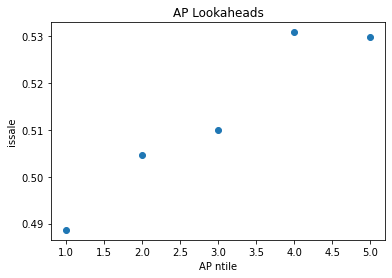

In [68]:
lookaheads_filter = (df_sme.data_split=='test')#&(df_sme.calltime > sme_end_time - datetime.timedelta(days=10))

df_lookaheads = pd.merge(df_sme[['agentid_cat',binary_metric_column]][lookaheads_filter],
                         df_scores[['AP']], how='inner', on='agentid_cat')
df_lookaheads['AP_ntile'] = np.ceil(df_lookaheads.AP * 5)
df_plot = df_lookaheads[['AP_ntile',binary_metric_column]].groupby('AP_ntile').mean()
plt.scatter(df_plot.index, df_plot[binary_metric_column])
plt.xlabel('AP ntile')
plt.ylabel(binary_metric_column)
plt.title('AP Lookaheads')
plt.show()

In [15]:
cd = os.getcwd()
with open(cd+'/'+feature_configs_file_name, "r") as text_file:
    data = text_file.read().replace("'","\"")
    #data = data.replace('N', '')
    feature_configs = json.loads(data)
text_file.close()